In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error as mse

In [2]:
def get_outliers_boundries(series):
    """Calculates the lower and upper bound for outliers using the formula:
    25th percentile - 1.5 IQR, 75th percentile + 1.5 IQR.
    
    Input: Pandas series
    Output: Python tuple of lower and upper bounds."""
    if type(series) != pd.Series:
        series = pd.Series(series)
    quantile_25 = series.quantile(0.25)
    quantile_75 = series.quantile(0.75)
    IQR = quantile_75 - quantile_25
    return (quantile_25 - IQR, quantile_75 + IQR)
get_outliers_boundries(pd.Series(np.arange(0, 1000)))

(-249.75, 1248.75)

In [3]:
# Set pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [4]:
# Read in csv files and display a few rows
hp = pd.read_csv('data/AmesHousing.csv')
hp.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [5]:
# Order and PID and indicies or unique identifiers so dropping those columns
for idx, col in hp.nunique().iteritems():
    if col == 2930:
        print(idx, col)
hp = hp.drop(['Order', 'PID'], axis=1)

Order 2930
PID 2930


[12. 11. 13.  9. 10.]


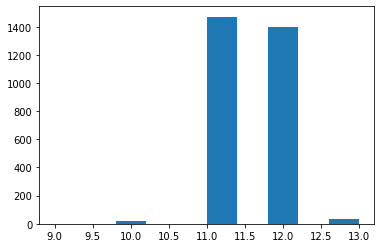

In [6]:
# Creating a stratification feature based on price to split the data.
hp['logprice'] = np.floor(np.log(hp['SalePrice']))
print(hp['logprice'].unique())
plt.hist(hp['logprice']);

In [7]:
# Make a copy of the original data before creating dummies
hp_orig = hp.copy()

In [8]:
# Get dummies for categorical features 
hp = pd.get_dummies(hp_orig)
columns_to_drop = [col for col in hp.columns if hp[col].sum() < 200]
hp = hp.drop(columns_to_drop, axis=1)
hp.head()

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,logprice,MS Zoning_RL,MS Zoning_RM,Street_Pave,Lot Shape_IR1,Lot Shape_Reg,Land Contour_Lvl,Utilities_AllPub,Lot Config_Corner,Lot Config_Inside,Land Slope_Gtl,Neighborhood_CollgCr,Neighborhood_NAmes,Neighborhood_OldTown,Condition 1_Norm,Condition 2_Norm,Bldg Type_1Fam,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1Story,House Style_2Story,Roof Style_Gable,Roof Style_Hip,Roof Matl_CompShg,Exterior 1st_HdBoard,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 2nd_HdBoard,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Exter Qual_Gd,Exter Qual_TA,Exter Cond_Gd,Exter Cond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Bsmt Qual_Ex,Bsmt Qual_Gd,Bsmt Qual_TA,Bsmt Cond_TA,Bsmt Exposure_Av,Bsmt Exposure_Gd,Bsmt Exposure_Mn,Bsmt Exposure_No,BsmtFin Type 1_ALQ,BsmtFin Type 1_BLQ,BsmtFin Type 1_GLQ,BsmtFin Type 1_Rec,BsmtFin Type 1_Unf,BsmtFin Type 2_Unf,Heating_GasA,Heating QC_Ex,Heating QC_Gd,Heating QC_TA,Central Air_Y,Electrical_SBrkr,Kitchen Qual_Ex,Kitchen Qual_Gd,Kitchen Qual_TA,Functional_Typ,Fireplace Qu_Gd,Fireplace Qu_TA,Garage Type_Attchd,Garage Type_Detchd,Garage Finish_Fin,Garage Finish_RFn,Garage Finish_Unf,Garage Qual_TA,Garage Cond_TA,Paved Drive_N,Paved Drive_Y,Fence_MnPrv,Sale Type_New,Sale Type_WD,Sale Condition_Normal,Sale Condition_Partial
0,20,141.0,31770,6,5,1960,1960,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,1,0,3,1,7,2,1960.0,2.0,528.0,210,62,0,0,0,0,0,5,2010,215000,12.0,1,0,1,1,0,1,1,1,0,1,0,1,0,1,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,1,1,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0
1,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010,105000,11.0,0,0,1,0,1,1,1,0,1,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,1,0,0,1,1,0,0,1,0,0,0,1,1,1,0,1,1,0,1,1,0
2,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010,172000,12.0,1,0,1,1,0,1,1,1,0,1,0,1,0,1,1,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,1,0,0,1,1,1,0,1,0,1,0,0,1,0,0,0,1,1,1,0,1,0,0,1,1,0
3,20,93.0,11160,7,5,1968,1968,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,2,1,3,1,8,2,1968.0,2.0,522.0,0,0,0,0,0,0,0,4,2010,244000,12.0,1,0,1,0,1,1,1,1,0,1,0,1,0,1,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,1,1,0,0,1,1,1,0,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,1,1,0
4,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,2,1,3,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,0,0,3,2010,189900,12.0,1,0,1,1,0,1,1,0,1,1,0,0,0,1,1,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,1,0,0,1,1,0,1,1,0,1,0,0,1,1,0,1,1,0,1,1,0


In [9]:
# for col in hp.columns:
#     if hp[col].isnull().any():
#         print(col)
#         hp['col'] = hp[col].fillna(0)
# print(hp.isnull().any())

In [10]:
# hp['Lot Frontage'] = hp['Lot Frontage'].fillna(0)
# hp[hp['Lot Frontage'].isnull()]

In [11]:
# Get a list of numeric columns
numeric_columns = []
for col in hp.columns:
    if hp[col].dtype.type in [np.float64, np.int64]:
        numeric_columns.append(col)
        hp[col] = hp[col].fillna(0)
len(numeric_columns)

37

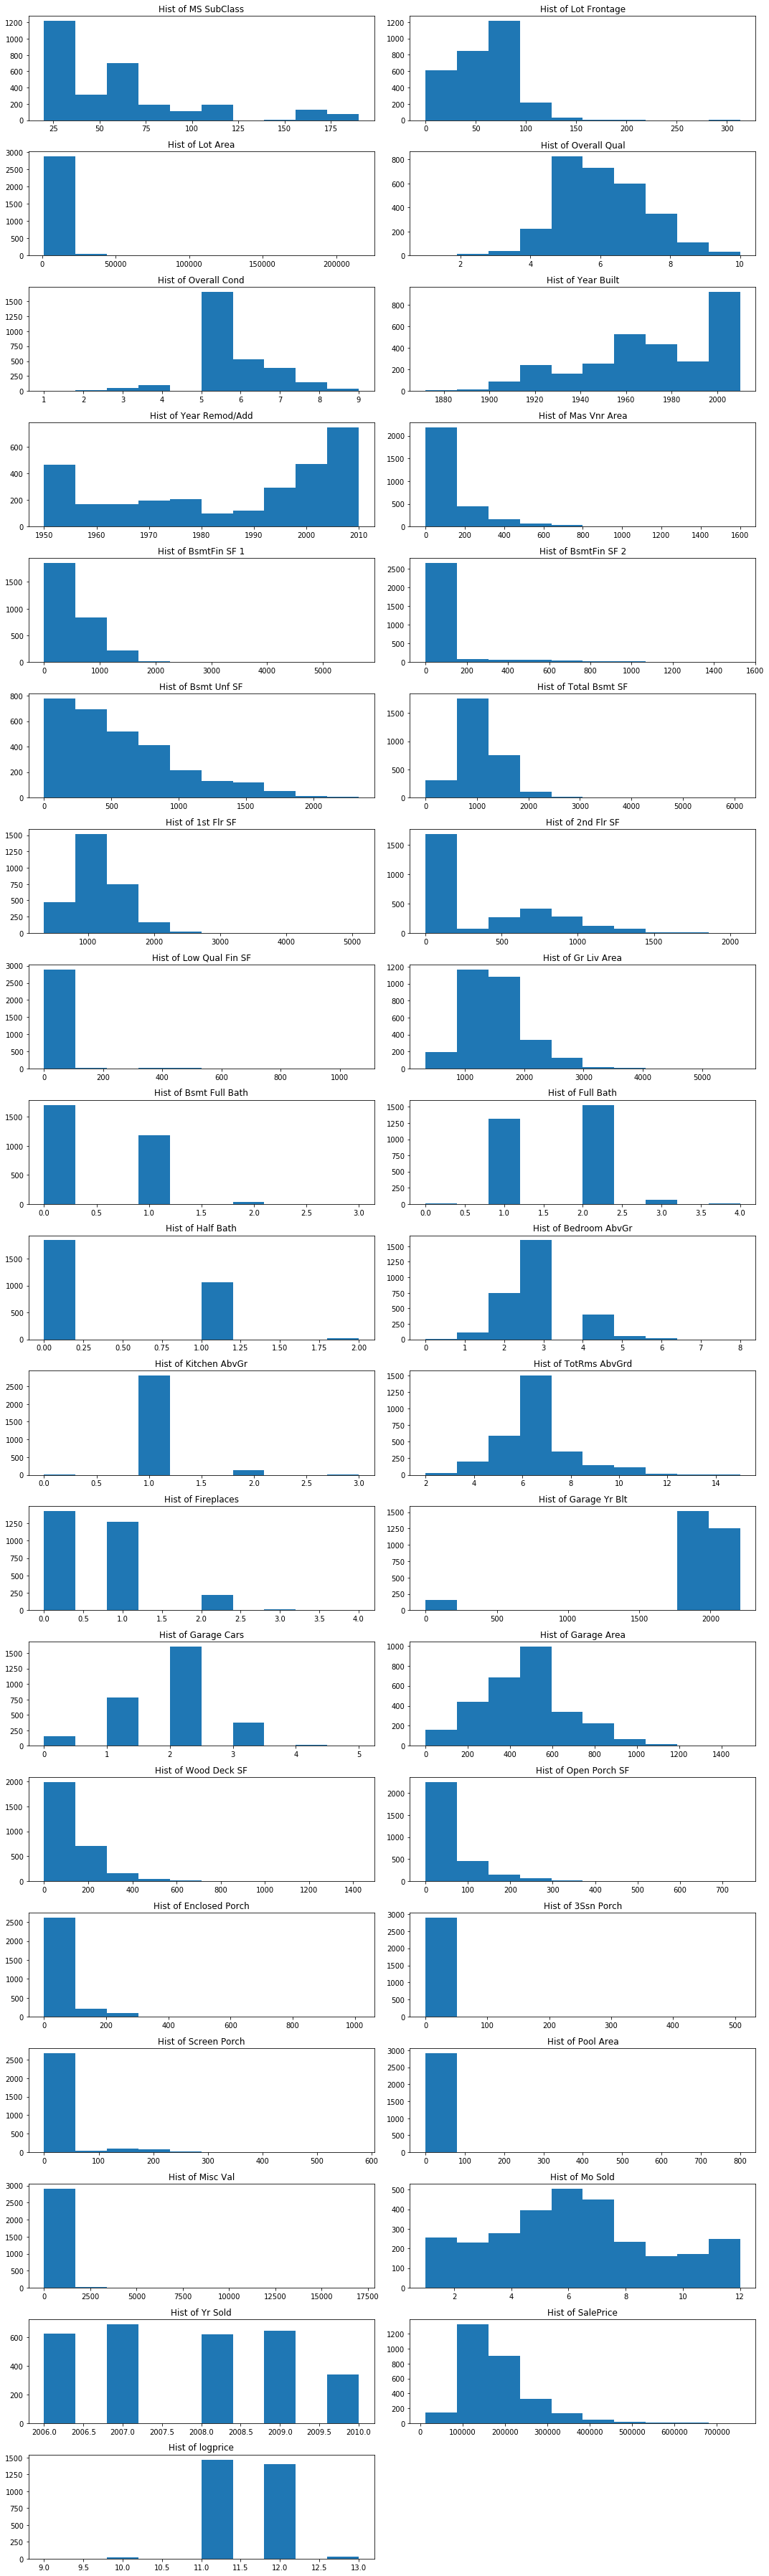

In [12]:
plt.figure(figsize=(15,50))
for idx, col in enumerate(numeric_columns[:]):
#     print(idx, col)
    plt.subplot((len(numeric_columns) // 2) + 1, 2, idx + 1)
    plt.hist(hp[col])
    plt.title('Hist of {}'.format(col))
plt.tight_layout()
plt.show()

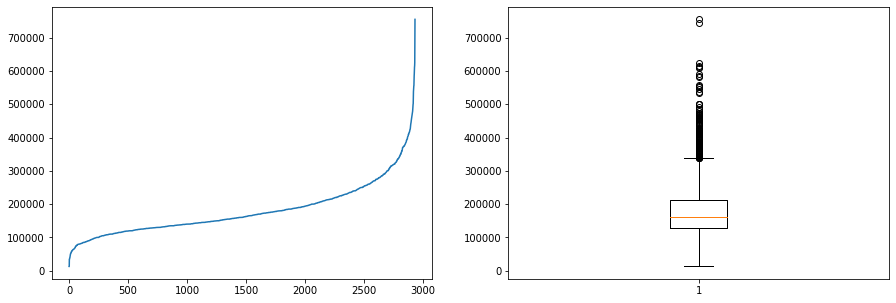

In [13]:
# View the sorted distribution of house prices.
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(hp['SalePrice'])+1), hp['SalePrice'].sort_values())
plt.subplot(1, 2, 2)
plt.boxplot(hp['SalePrice']);

In [14]:
price_iqr = hp['SalePrice'].quantile(0.75) - hp['SalePrice'].quantile(0.25)
high_outlier = hp['SalePrice'].quantile(0.75) + price_iqr * 1.5
print('Median House Price:', hp['SalePrice'].quantile(0.5))
print('High Price Outlier:', high_outlier)

Median House Price: 160000.0
High Price Outlier: 339500.0


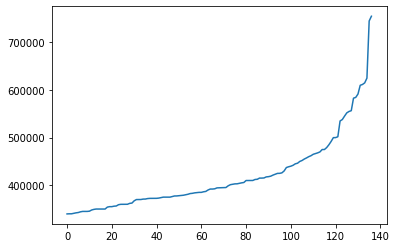

In [15]:
outliers = hp[hp['SalePrice'] >= high_outlier]
plt.plot(np.arange(0, len(outliers)), outliers['SalePrice'].sort_values())

In [16]:
# Dropping outliers since even outliers have an exponential curve.
hp = hp.drop(outliers.index, axis=0)

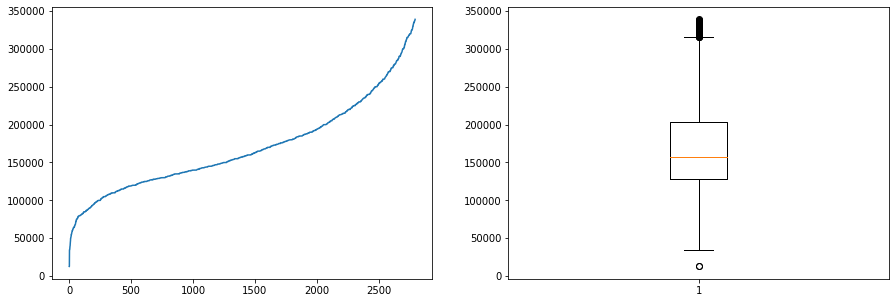

In [17]:
# View the sorted distribution of house prices.
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(hp['SalePrice'])+1), hp['SalePrice'].sort_values())
plt.subplot(1, 2, 2)
plt.boxplot(hp['SalePrice']);

In [18]:
hp[numeric_columns].head()

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,logprice
0,20,141.0,31770,6,5,1960,1960,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,1,0,3,1,7,2,1960.0,2.0,528.0,210,62,0,0,0,0,0,5,2010,215000,12.0
1,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010,105000,11.0
2,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010,172000,12.0
3,20,93.0,11160,7,5,1968,1968,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,2,1,3,1,8,2,1968.0,2.0,522.0,0,0,0,0,0,0,0,4,2010,244000,12.0
4,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,2,1,3,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,0,0,3,2010,189900,12.0


In [19]:
# Split data for modeling.
X_train, X_test, y_train, y_test = train_test_split(hp.drop('SalePrice',axis=1),
                                                    hp['SalePrice'], shuffle=True,
                                                    random_state=42, test_size=0.2,
                                                    stratify=hp['logprice'])

In [20]:
# Drop logprice to prevent price information from leaking into the training data.
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.drop('logprice', axis=1, inplace=True)
X_test.drop('logprice', axis=1, inplace=True)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2234, 119) (2234,) (559, 119) (559,)
(2234, 118) (2234,) (559, 118) (559,)


In [21]:
# Create a basic pipeline or StandardScaler and LinearRegression
pipe = make_pipeline(StandardScaler(), LinearRegression())

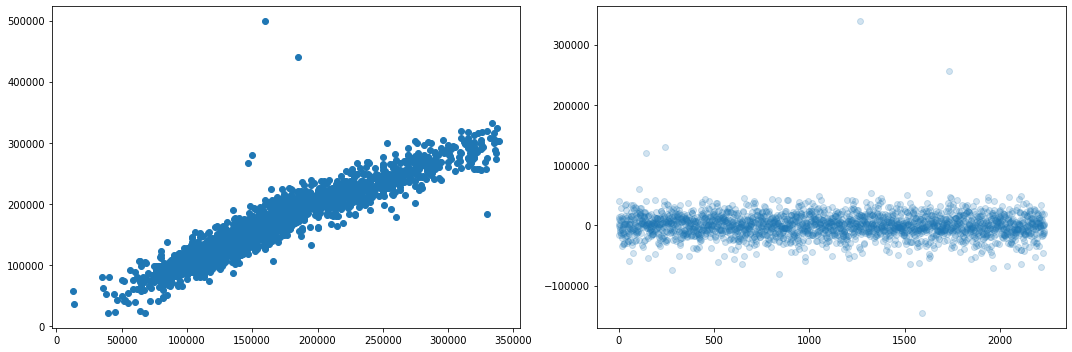

In [22]:
pipe.fit(X_train, y_train)
y_predict = pipe.predict(X_train)
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_predict)
plt.subplot(1, 2, 2)
plt.scatter(np.arange(0, len(y_train)), y_predict - y_train, alpha=0.2)
plt.tight_layout()
plt.show()

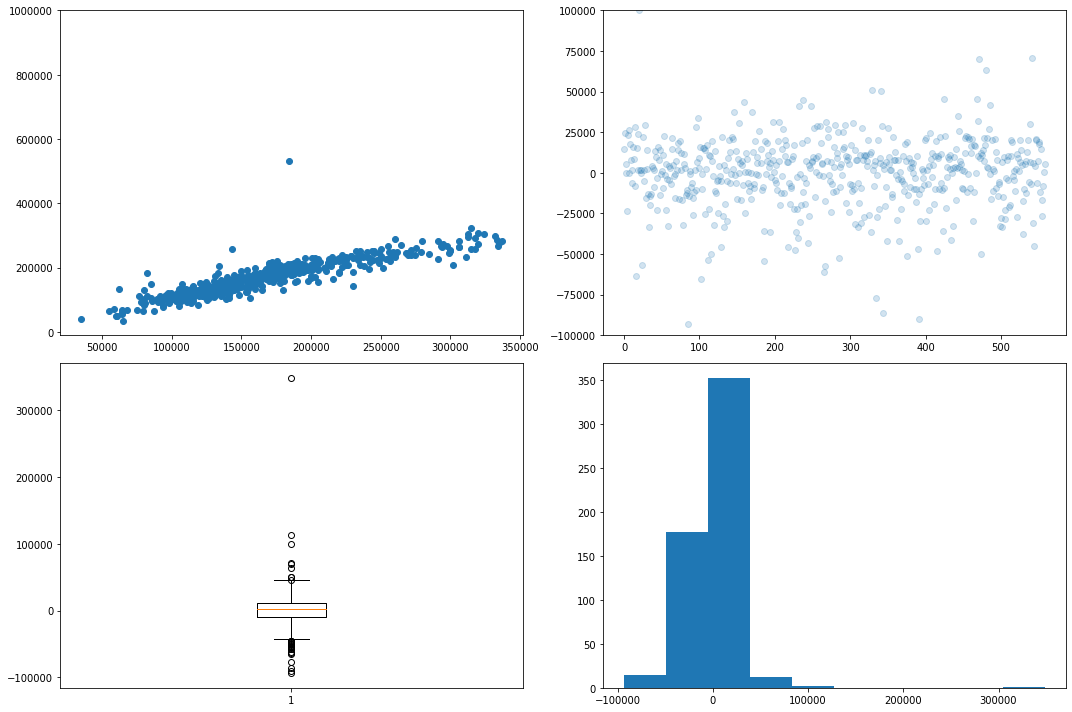

In [23]:
y_test_predict = pipe.predict(X_test)
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_test_predict)
plt.ylim([-10000,1000000])
plt.subplot(2, 2, 2)
plt.scatter(np.arange(0, len(y_test)), y_test_predict - y_test, alpha=0.2)
plt.ylim([-100000,100000])
plt.subplot(2, 2, 3)
plt.boxplot(y_test_predict - y_test)
plt.subplot(2, 2, 4)
plt.hist(y_test_predict - y_test)
plt.tight_layout()
plt.show()

In [24]:
# Get the low outliers and see what is going on
residuals = pd.Series(y_test_predict - y_test, index=y_test.index)
residuals_quantiles = (residuals.quantile(0.25), residuals.quantile(0.50), residuals.quantile(0.75),)
residuals_iqr = residuals_quantiles[2] - residuals_quantiles[0]
low_outlier = residuals_quantiles[0] - residuals_iqr * 1.5
residuals[residuals < low_outlier]

39     -63790.063611
296    -57072.458054
1945   -93326.626035
1014   -65409.848841
2308   -53992.146398
919    -50293.791188
2444   -45737.598007
1586   -54280.714720
59     -45927.509399
48     -47435.445389
1686   -61334.623112
2218   -57562.492717
1069   -52417.637666
1538   -77302.821409
2892   -86459.407405
274    -50993.608755
1827   -46690.836337
945    -90313.052938
751    -47870.278444
2074   -49764.293454
1401   -45032.546364
Name: SalePrice, dtype: float64

In [25]:
# Two predictions are wildly low.
ytp = pd.Series(y_test_predict, index=y_test.index)
print(ytp.loc[1861])
print(ytp.loc[1401])

204842.8478831953
196467.45363613043


In [26]:
# Split the data into three parts for cross validation
kf = KFold(n_splits=3, random_state=42, shuffle=True)
print(kf)
for train_index, test_index in kf.split(X_train, y_train):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)

KFold(n_splits=3, random_state=42, shuffle=True)
TRAIN: (1489,) TEST: (745,)
TRAIN: (1489,) TEST: (745,)
TRAIN: (1490,) TEST: (744,)


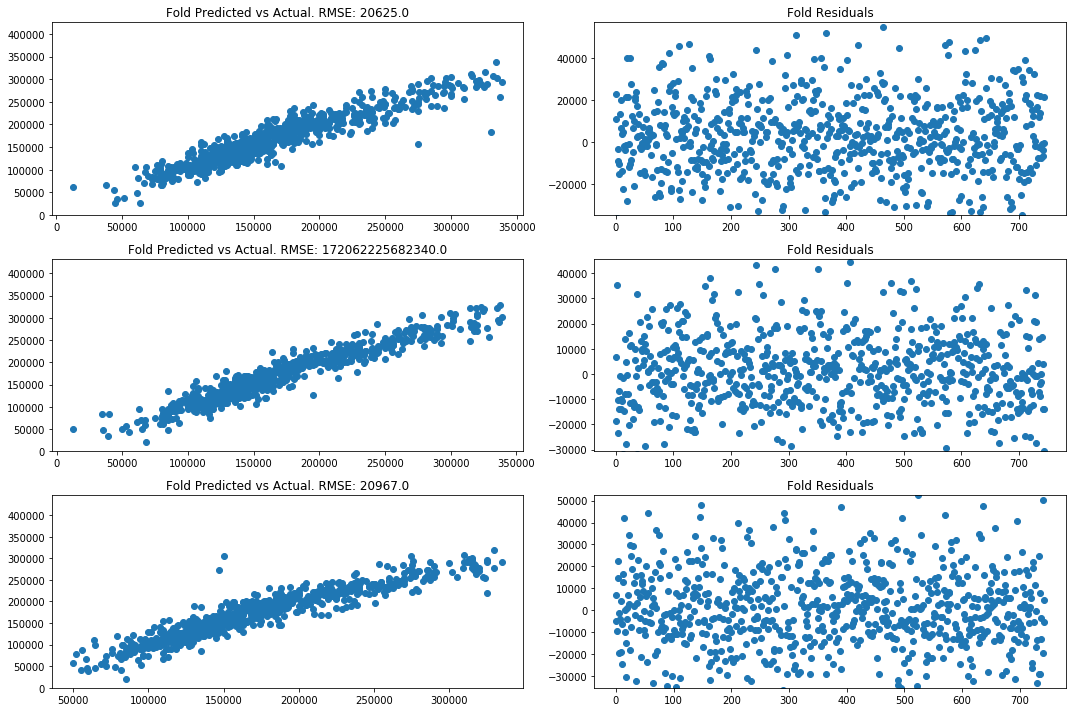

In [30]:
scores = []
index = 1
plt.figure(figsize=(15,10))
for train_index, test_index in kf.split(X_train, y_train):
    x_train_cv = X_train.values[train_index]
    y_train_cv = y_train.values[train_index]
#     print('x_train_cv:', x_train_cv.shape)
#     print('y_train_cv:', y_train_cv.shape)
    x_test_cv = X_train.values[test_index]
    y_test_cv = y_train.values[test_index]
#     print('x_test_cv:', x_test_cv.shape)
#     print('y_test_cv:', y_test_cv.shape)
    pipe.fit(x_train_cv, y_train_cv)
    fold_predict = pipe.predict(x_test_cv)
    plt.subplot(3, 2, index)
    plt.scatter(y_test_cv, fold_predict)
    low, high = get_outliers_boundries(fold_predict)
    plt.ylim(0, high * 1.5)
    plt.title('Fold Predicted vs Actual. RMSE: {}'.format(round(np.sqrt(mse(y_test_cv, fold_predict)))))
    index += 1
    plt.subplot(3, 2, index)
    plt.scatter(np.arange(0, len(test_index)), fold_predict - y_test_cv)
    low, high = get_outliers_boundries(fold_predict - y_test_cv)
    plt.ylim(low, high * 1.5)
    plt.title('Fold Residuals')
    index += 1
plt.tight_layout()
plt.show()

hp.describe()

In [28]:
def backward_elimination(X, y):
    pipe = make_pipeline(StandardScaler(), LinearRegression())
    rmse = {'before': 0, 'after': 0}
    pipe.fit(X, y)
    
    for col in

0